
#Magic Animate

**Magic Animate is a diffusion-based framework designed to create videos from images by applying specific motion sequences**. The usage of this technique for human image animation has gained a lot of attention given its potential application across various domains, including social media, the movie industry, and entertainment.

Compared with other solutions, Magic Animate is particularly good in maintaining temporal consistency, and preserving reference image faithfully. The solution overall pipeline is shown below.

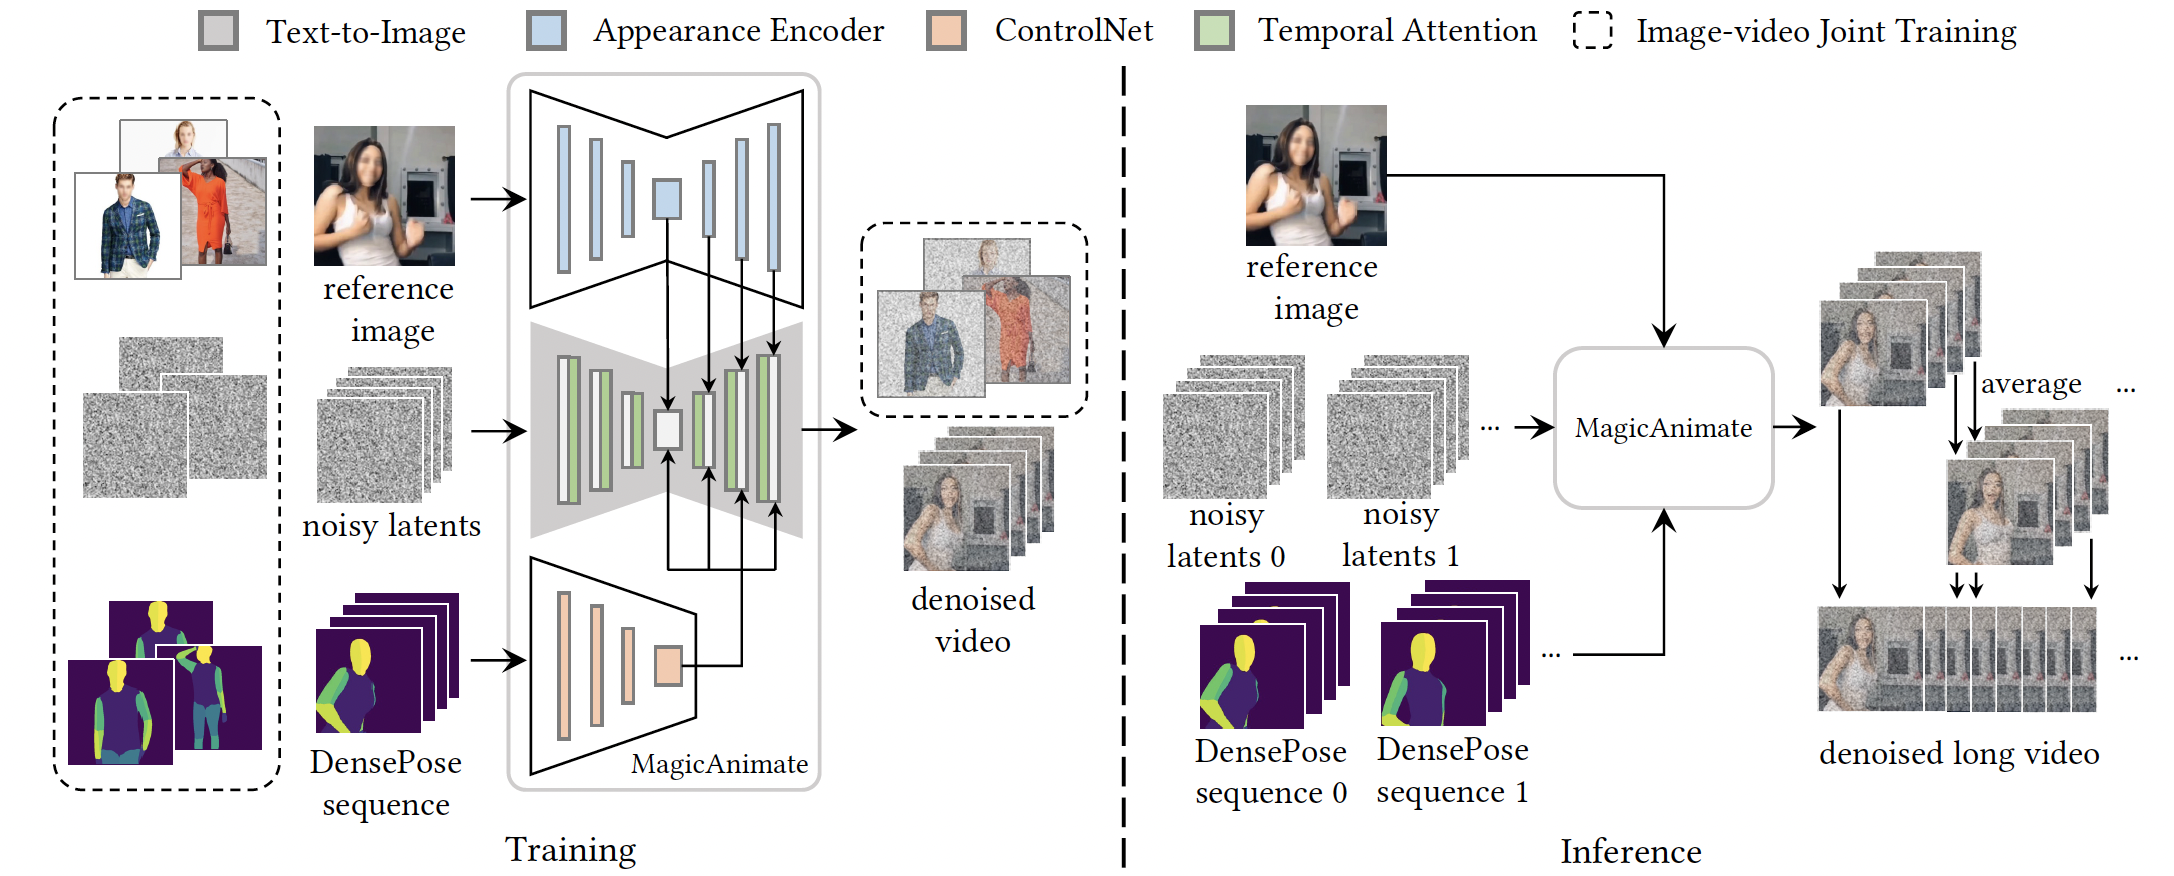

The image is first embed into appearance embeddings - using an appearance encoder. Then a target pose sequence is passed as input to a pose control net to extract motion condition. Utilizing both signals, a video diffusion model is trained to animate the specified human identity, aligning with the provided motions.

To know more, [acces the paper](https://arxiv.org/abs/2311.16498).

```BibTeX
@inproceedings{xu2023magicanimate,
    author    = {Xu, Zhongcong and Zhang, Jianfeng and Liew, Jun Hao and Yan, Hanshu and Liu, Jia-Wei and Zhang, Chenxu and Feng, Jiashi and Shou, Mike Zheng},
    title     = {MagicAnimate: Temporally Consistent Human Image Animation using Diffusion Model},
    booktitle = {arXiv},
    year      = {2023}
}
```

#Environment setup

GPU usage is necessary to execute this code. Google Colab offers a free GPU environment. To access it, navigate to the top of the page, select `Runtime`, then choose `Change runtime type`, and opt for` T4 GPU`.

Once done, proceed with the following steps to set up the environment 👇


In [ ]:
#@markdown ### Installing Detectron
#@markdown The detectron framework will be used for for generating Pose Estimations and body segmentation.


#@markdown If everything goes as expected, you are going to see the following message:


#@markdown `NVIDIA (R) Cuda compiler driver`  <br> `Copyright (c) 2005-2023 NVIDIA Corporation` <br> `Built on Tue_Aug_15_22:02:13_PDT_2023` <br> `Cuda compilation tools, release 12.2, V12.2.140` <br> `Build cuda_12.2.r12.2/compiler.33191640_0` <br> `torch:  2.1 ; cuda:  cu121` <br> `detectron2: 0.6`

#@markdown ⌛ 1 min
!python -m pip install pyyaml==5.1  &> /dev/null
!pip install av  &> /dev/null

import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'  &> /dev/null
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}  &> /dev/null
sys.path.insert(0, os.path.abspath('./detectron2'))

import torch
import numpy as np

from pathlib import Path
from tqdm import tqdm
import cv2

import detectron2
from detectron2.engine.defaults import DefaultPredictor
from detectron2.data.detection_utils import read_image

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [ ]:
#@markdown ### Run this cell to install the required libraries and dowload models weights

#@markdown ⌛ 12 min

import typer

#Downloading dense pose
typer.echo(typer.style("Dowloading Dense Pose Weights...", fg=typer.colors.BRIGHT_YELLOW))
%cd /content/detectron2/projects/DensePose
!curl -O https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl &> /dev/null
typer.echo(typer.style("Dense Pose ✅ \n", fg=typer.colors.GREEN))

#Cloning and installing magic animate
typer.echo(typer.style("Downloading Magic Animate weights and installing required libraries...", fg=typer.colors.BRIGHT_YELLOW))
%cd /content/
!git clone https://github.com/hugozanini/magic-animate.git &> /dev/null
%cd magic-animate
!pip install -r requirements.txt &> /dev/null
!git clone https://huggingface.co/stabilityai/sd-vae-ft-mse /content/magic-animate/pretrained_models/sd-vae-ft-mse/ &> /dev/null
!git lfs clone https://huggingface.co/zcxu-eric/MagicAnimate /content/magic-animate/pretrained_models/MagicAnimate/ &> /dev/null
typer.echo(typer.style("Magic Animate ✅ \n", fg=typer.colors.GREEN))
!pip install langchain &> /dev/null
!pip install sentence-transformers &> /dev/null

#Downloading models
typer.echo(typer.style("Dowloading Stable Diffusion Weights...", fg=typer.colors.BRIGHT_YELLOW))
!git clone -b fp16 https://huggingface.co/runwayml/stable-diffusion-v1-5 /content/magic-animate/pretrained_models/stable-diffusion-v1-5/ &> /dev/null
typer.echo(typer.style("Stable Diffusion ✅ \n", fg=typer.colors.GREEN))


%cd /content/detectron2/projects/DensePose
#Importing libraries


from densepose.vis.extractor import (
    DensePoseOutputsExtractor,
    DensePoseResultExtractor,
)
from densepose.structures import (
    DensePoseChartPredictorOutput,
    DensePoseEmbeddingPredictorOutput
)

from densepose.structures import DensePoseDataRelative
from densepose.vis.base import Boxes, Image, MatrixVisualizer
from apply_net import DumpAction
from apply_net import create_argument_parser




typer.echo(typer.style("All set ✅", fg=typer.colors.GREEN))


Dowloading Dense Pose Weights...
/content/detectron2/projects/DensePose
Dense Pose ✅ 

/content
/content/magic-animate
Magic Animate ✅ 

Dowloading Stable Diffusion Weights...
Stable Diffusion ✅ 

/content/detectron2/projects/DensePose
All set ✅


In [ ]:
#@markdown ### Creating poses and segmentation masks from a Google Drive video

#@markdown You need a video to be used as a motion sequence reference to the model.

#@markdown Enter the Google Drive path where the  video is stored.

#from google.colab import drive
#drive.mount('/content/drive')

# Uncomment to copy generated images to drive, faster than downloading directly from colab in my experience.
from google.colab import drive
from pathlib import Path # Importing Path from pathlib
drive_mount_path = Path("/") / "content" / "drive"
drive.mount(str(drive_mount_path))
drive_mount_path /= "MyDrive"
#@markdown ---
drive_path = "/colab_notebooks/teste05.mp4" #@param {type:"string"}
#@markdown ---
#@markdown ⌛ Depends on the video size

#@markdown ⚠️ The estimation provided by the progress bar can be wrong


# Calling the functions
%cd /content/detectron2/projects/DensePose
# Import apply_net
import sys, os
sys.path.append(os.getcwd()) # Add current working directory to Python path

from apply_net import DumpAction, create_argument_parser # Import create_argument_parser and DumpAction
input_path = str(drive_mount_path) + drive_path
output_path = input_path.split(".")[0]+"_masked.mp4"



#def process_mask(input_path, output_path):
parser = create_argument_parser()
args = parser.parse_args(args=[
    "dump",
    "configs/densepose_rcnn_R_50_FPN_s1x.yaml",
    "model_final_162be9.pkl",
    "input.jpg",
    "--output",
    "dump.pkl"
])

opts = []
cfg = DumpAction.setup_config(args.cfg, args.model, args, opts)

predictor = DefaultPredictor(cfg)
context = DumpAction.create_context(args, cfg)

count = 0
cap = cv2.VideoCapture(input_path)

img_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
img_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

img_size = 512 #Model input size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(output_path, fourcc, 25.0, (img_size, img_size))


fps = cap.get(cv2.CAP_PROP_FPS)
total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
length = total_frame_count/fps


val_scale = 255.0 / DensePoseDataRelative.N_PART_LABELS

mask_visualizer = MatrixVisualizer(
    inplace=True, cmap=cv2.COLORMAP_VIRIDIS, val_scale=val_scale, alpha=1.0
)
typer.echo(typer.style("Creating segmentation Mask...", fg=typer.colors.BRIGHT_YELLOW))



def predict(img, predictor):
    with torch.no_grad():
        outputs = predictor(img)["instances"]
        outputs = outputs.to("cpu")
    return outputs

def generator():
  while True:
    yield


with tqdm(total=total_frame_count, position=0, leave=True) as pbar:
  while True:
      ret, img = cap.read()
      if not ret:
          break

      # Predict and send to CPU
      outputs = predict(img, predictor)
      otutpus = outputs.to("cpu")

      # Extract inference results
      extractor = DensePoseResultExtractor()
      data = extractor(outputs)
      densepose_result, boxes_xywh = data

      # Use cv2.COLORMAP_VIRIDIS for rendering colors
      matrix_scaled_8u = np.zeros((img_height, img_width), dtype=np.uint8)
      matrix_vis = cv2.applyColorMap(matrix_scaled_8u, cv2.COLORMAP_VIRIDIS)

      for i, result in enumerate(densepose_result):
          # Applying segmentation mask
          iuv_array = torch.cat(
              (result.labels[None].type(torch.float32), result.uv * 255.0)
          ).cpu().type(torch.uint8).cpu().numpy()

          bbox_xywh = boxes_xywh.cpu().numpy()[0]
          def _extract_i_from_iuvarr(iuv_arr):
              return iuv_arr[0, :, :]

          matrix = _extract_i_from_iuvarr(iuv_array)
          segm = _extract_i_from_iuvarr(iuv_array)
          mask = np.zeros(matrix.shape, dtype=np.uint8)
          mask[segm >= 0] = 1

          mask_visualizer.visualize(matrix_vis, mask, matrix, bbox_xywh)

          # Segmenting only use person. Stopping the loop in the second person
          break

      # Padding for keeping the frame proportions
      height, width = matrix_vis.shape[:2]
      if height > width:
        pad = (height - width) // 2
        matrix_vis = np.pad(matrix_vis, ((0, 0), (pad, pad), (0, 0)), 'edge')
      elif width > height:
        pad = (width - height) // 2
        matrix_vis = np.pad(matrix_vis, ((pad, pad), (0, 0), (0, 0)), 'edge')

      matrix_vis = cv2.resize(matrix_vis, (img_size, img_size), cv2.INTER_NEAREST)
      writer.write(matrix_vis)
      pbar.update(1)

writer.release()
cap.release()

typer.echo(typer.style("\nSegmentation mask saved at "+ output_path + " ✅", fg=typer.colors.GREEN))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/detectron2/projects/DensePose
Creating segmentation Mask...


  0%|          | 0/402 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 402/402 [02:18<00:00,  2.91it/s]


Segmentation mask saved at /content/drive/MyDrive/colab_notebooks/teste05_masked.mp4 ✅


In [ ]:
!pip3 install numpy==1.24.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 104.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.0 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.0 which is incompatible.
bokeh 3.4.3 requires contourpy>=1.2, but you have contourpy 1.1.0 which is incompatible.
chex 0.1.87 requires numpy>=1.24.1, but you have numpy 1.24.0 which is incompatible.
cudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 13.0.0 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.
plotnine 0.14.0 requires matplotlib>=3.8.0, 

In [ ]:
#@markdown # **Running Magic Animate**

#@markdown 1. Place the motion sequence video generated earlier into the `input_video_path`. \
#@markdown 2. Add the path of the image you wish to animate to `input_image_path`.\
#@markdown 3. Specify the location where you want to save the resulting video in `output_video_path`.


#@markdown Google Drive folders:

from google.colab import drive
from pathlib import Path
drive_mount_path = Path("/") / "content" / "drive"
drive.mount(str(drive_mount_path))
drive_mount_path /= "MyDrive"


input_video_path = "/content/drive/MyDrive/colab_notebooks/teste05_masked.mp4" #@param {type:"string"}
input_image_path = "/content/drive/MyDrive/colab_notebooks/fototeste04.jpg" #@param {type:"string"}

output_video_path = "/content/drive/MyDrive/colab_notebooks/outputs" #@param {type:"string"}
#@markdown ---

#@markdown ###Model parameters

#@markdown These are the default model parameters, but feel free to change according your experiments.

seed = 2 #@param {type:"slider", min:-0.0, max:10, step:1}

#@markdown
steps = 35 #@param {type:"slider", min:-0.0, max:100, step:1}

#@markdown
guidance_scale = 7.5 #@param {type:"slider", min:-0.0, max:100, step:0.25}


%cd /content/magic-animate


from PIL import Image
import imageio
import numpy as np

from demo.animate import MagicAnimate


def read_image(image_path, size=512):
    image = Image.open(image_path)
    return np.array(image.resize((size, size)))


animator = MagicAnimate()

reference_image = read_image(input_image_path)
motion_sequence = input_video_path

animation = animator(reference_image, motion_sequence, seed, steps, guidance_scale, output_video_path)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/magic-animate


ImportError: cannot import name 'cached_download' from 'huggingface_hub' (/usr/local/lib/python3.10/dist-packages/huggingface_hub/__init__.py)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
